# Probabilistic K-Nearest Neighbors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import randn, randint, rand
from tqdm.notebook import tqdm

from sklearn.metrics import (confusion_matrix, precision_score,
                             recall_score, precision_recall_curve)

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (8, 4)

## The main idea

* [A probabilistic nearest neighbour method for
statistical pattern recognition](http://hedibert.org/wp-content/uploads/2016/02/holmes-adams-2002.pdf) [Holmes and Adams, 2001]
* [Machine Learning Strategies for Time Series Forecasting](https://link.springer.com/chapter/10.1007/978-3-642-36318-4_3)[Bontempi, et. al., 2012]
* Time series as "signals" [Lopez de Prado, 2019]

In [3]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = np.random.randn(nsteps - 1)
    
    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
        x[t + 1] = x[t] * cnst0 + cnst1 + cnst2 * errs[t]
        

    return time, x


def ts_supervised(data, n_in=1, n_out=1):
    """
    Transform a matrix of size TxS to a supervised machine learning
    problem.
    
    n_in: int
        The number of previous steps to consider. This is the
        X matrix of values (x_{t-n_in}, ..., x_{t-1}) as input 
        to the model
        
    n_out: int
        The number of posterior steps to consider. This is a 
        Y matrix of values (y_{t}, y_{t+1}, ..., y_{t+n_out})
        which serves as output to the model
    """
    _, n_vars = data.shape
    base_cols = data.columns
    cols, col_names = [], []
    agg = {}
    # Input sequence (t-n, .., t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        col_names.extend([f"{base_cols[j-1]}(t-{i})"
                          for j in range(1, n_vars + 1)])
    # forecast sequence (t, .., t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        col_names.extend([f"{base_cols[j-1]}(t+{i})".replace("+0", "")
                           for j in range(1, n_vars + 1)])

    agg = pd.concat(cols, axis=1).dropna()
    agg.columns = col_names
    return agg


def compute_distance(x, X):
    D = ((x[..., None] - X.T[:, None, :]) ** 2).sum(axis=0)
    return D

def find_k_closest(X, k=6):
    D = compute_distance(X.T, X)
    nearest = np.argsort(D)[..., 1 :k + 1]
    return nearest


def compute_likelihood(X, y, beta, k):
    Q = len(np.unique(y))
    # Comparing the "k" closest datapoints of xi to yi
    num = y[find_k_closest(X, k=k)] == y[:, None]
    num = np.exp(beta * num.mean(axis=1))
    
    den = y[find_k_closest(X, k=k), None] == np.arange(Q)[None, None, :]
    den = np.exp(beta * den.mean(axis=1)).sum(axis=-1)
    
    likelihood = num / den
    return likelihood.prod()


def knn_mcmc(X, y, k, beta, target_samples=10_000, eta=1):
    samples = []
    n_rounds = 0
    pbar = tqdm(total=target_samples)
    while len(samples) < target_samples:
        n_rounds += 1
        beta_hat = np.abs(beta + randn() * eta)

        k_hat = np.abs(k + randint(-4, 4))
        k_hat = max(1, k_hat)

        L_hat = compute_likelihood(X, y, beta_hat, k_hat)
        L = compute_likelihood(X, y, beta, k)
        A = min(1, L_hat / L)
        if A > rand():
            samples.append([k_hat, beta_hat])
            k, beta = k_hat, beta_hat
            pbar.update(1)
    return np.array(samples), target_samples / n_rounds

## The Orstein-Uhlenbeck Process

An OU Process is given by

$$
    dS_{t+1} = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where

* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the stardard deviation of the process

In this example, we will train a pknn using an OU-process.

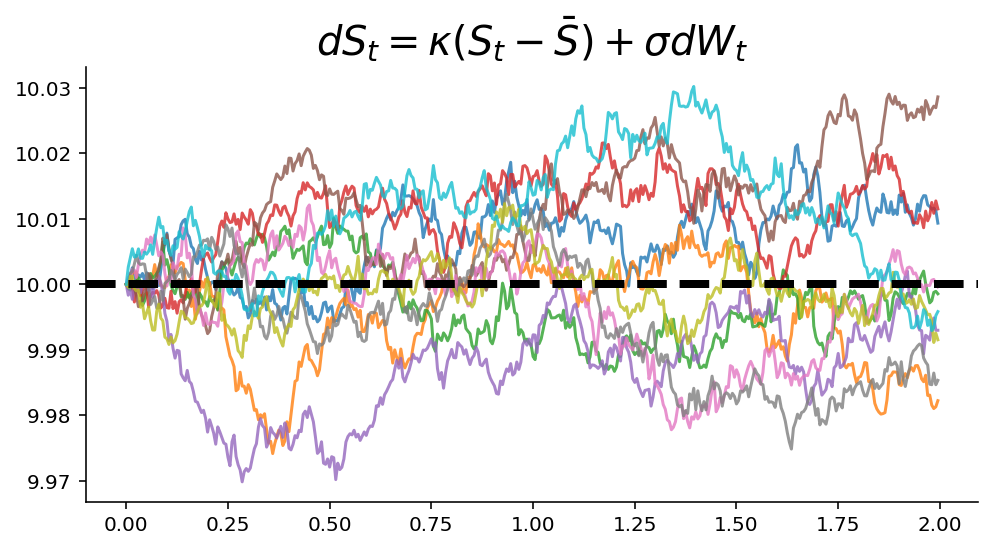

In [4]:
np.random.seed(314)
xbar = 10

for _ in range(10):
    plt.plot(*simulate_ou_process(10, xbar, 1, 0.02, T=2, dt=0.005),
             alpha=0.8)
plt.axhline(y=xbar, linewidth=4, c="black", linestyle="--");
plt.title(r"$dS_t = \kappa (S_t - \bar S) + \sigma dW_t$", fontsize=20);
plt.savefig("simulations.pdf")

### Generating the training data

In [5]:
np.random.seed(3141)
x0, xbar = 10, 10
T = 400
kappa, sigma, dt = 0.3, 1, 0.3
# kappa, sigma, dt = 0.6, 0.5, 0.3 # An 'easy' configuration
t, St = simulate_ou_process(x0, xbar, kappa, sigma, T=T, dt=dt)
St = pd.DataFrame({"S": St}, index=t)

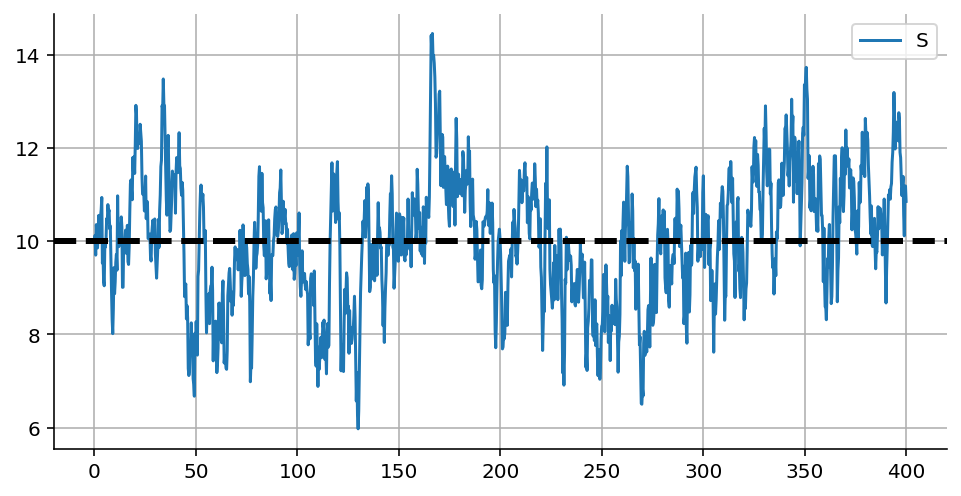

In [6]:
St.plot()
plt.grid()
plt.axhline(y=xbar, linewidth=3, c="black", linestyle="--", zorder=2)

In [7]:
n_in, n_out = 10, 10
X = ts_supervised(St, n_in=n_in, n_out=n_out)
X.shape

(1315, 20)

In this first exercise, we will focus in capturing mean-reverting tredns that are below $\bar S$. We are interested in knowning whether the model can correctly "enter" the market.

In [8]:
n_periods = 8

In [9]:
X_below = X[X["S(t)"] < xbar]

y_below = (X_below.iloc[:, -n_periods:] > xbar).any(axis=1) * 1.
X_below = X_below.loc[:, :"S(t)"].values

In [10]:
y_below.mean()

0.5340729001584786

In [11]:
X_below.shape[0] / X.shape[0]

0.47984790874524713

In [64]:
target_samples = 5_000

In [66]:
samp1, prop_accept1 = knn_mcmc(X_below, y_below.values, k=2, beta=0, target_samples=target_samples)

In [71]:
samp2, prop_accept2 = knn_mcmc(X_below, y_below.values, k=1, beta=1, target_samples=target_samples)

In [126]:
prop_accept1, prop_accept2

(0.1288825879623663, 0.12560289389067525)

In [128]:
load_chains = True
save_chains = False

chains = np.concatenate((samp1[None, ...], samp2[None, ...]), axis=0)
if save_chains:
    np.save("chain", chains)

if load_chains:
    chains = np.load("chain.npy")

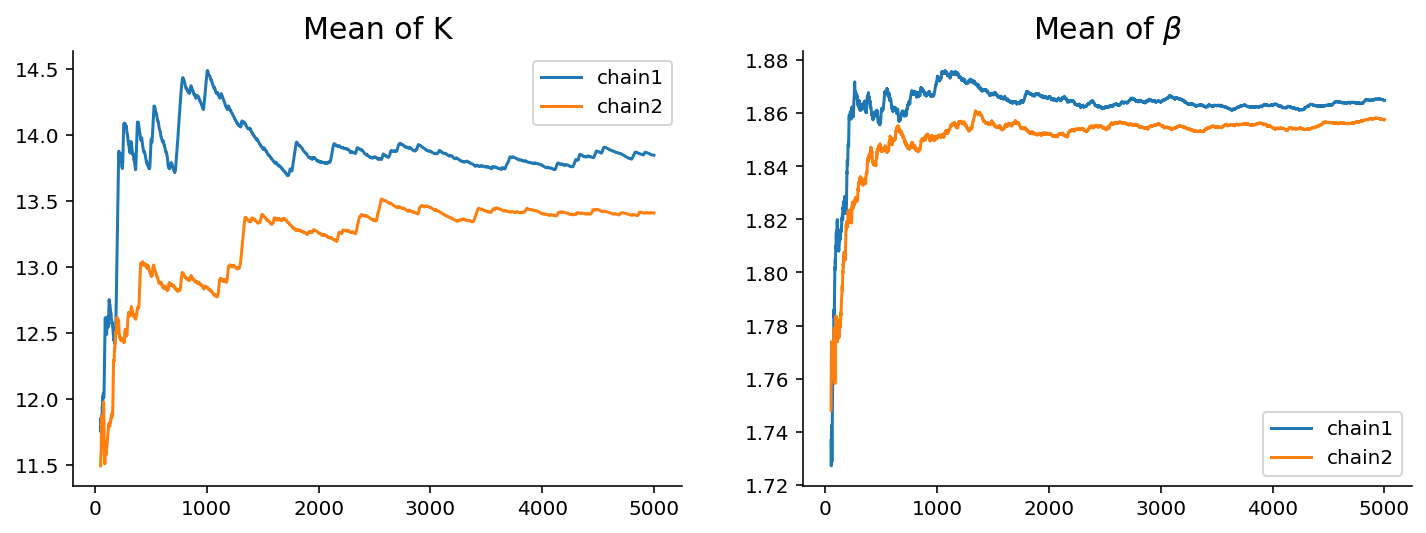

In [15]:
nparams, chain_length, nchains = chains.shape
N_range = np.arange(1, chain_length + 1)

mu_chain = chains.cumsum(axis=1) / N_range[None, :, None]

labels = ["K", r"$\beta$"]
nskip = 50
domain = N_range[nskip:]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, (axi, label) in enumerate(zip(ax, labels)):
    axi.plot(domain, mu_chain[0, nskip:, i], label="chain1")
    axi.plot(domain, mu_chain[1, nskip:, i], label="chain2")
    axi.set_title(f"Mean of {label}", fontsize=15)
    axi.legend()

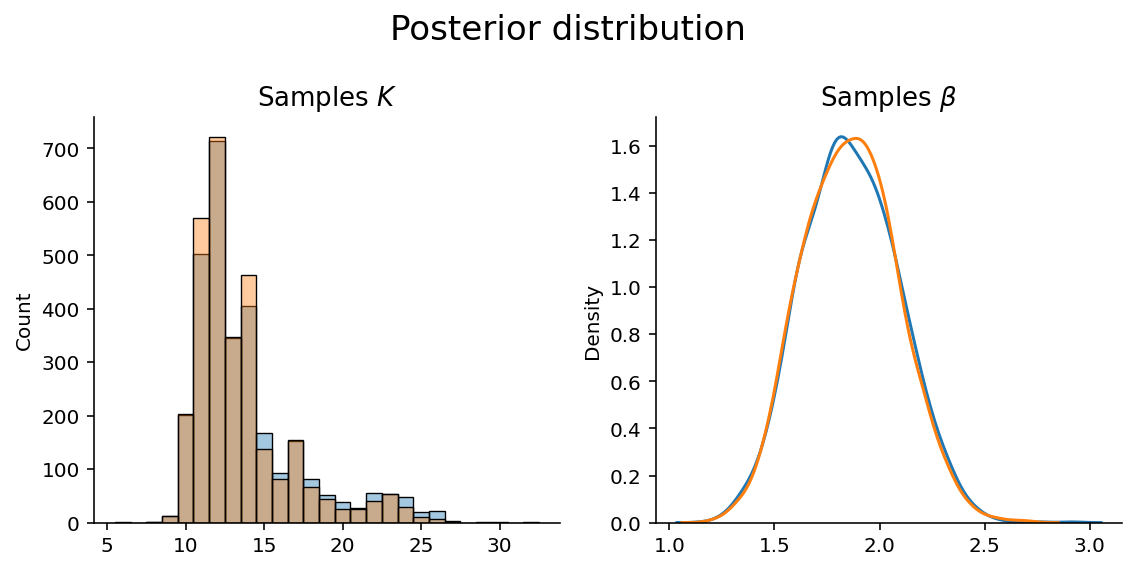

In [16]:
fig, ax = plt.subplots(1, 2)
burnout = 2000
sns.histplot(chains[0, burnout:, 0], ax=ax[0], alpha=0.4, discrete=True)
sns.histplot(chains[1, burnout:, 0], ax=ax[0], alpha=0.4, color="tab:orange", discrete=True)

sns.kdeplot(chains[0, burnout:, 1], ax=ax[1], alpha=0.2, color="tab:blue")
sns.kdeplot(chains[1, burnout:, 1], ax=ax[1], alpha=0.2, color="tab:orange")
ax[0].set_title("Samples $K$", fontsize=13)
ax[1].set_title(r"Samples $\beta$", fontsize=13)
plt.suptitle("Posterior distribution", fontsize=17);
plt.tight_layout()
plt.savefig("posterior-config.pdf")

## Testing the model

In [17]:
np.random.seed(31415)
T = 100
t, St_test = simulate_ou_process(St.iloc[-1].item(), xbar, kappa, sigma, T=T, dt=dt)
St_test = pd.DataFrame({"S": St_test}, index=t)

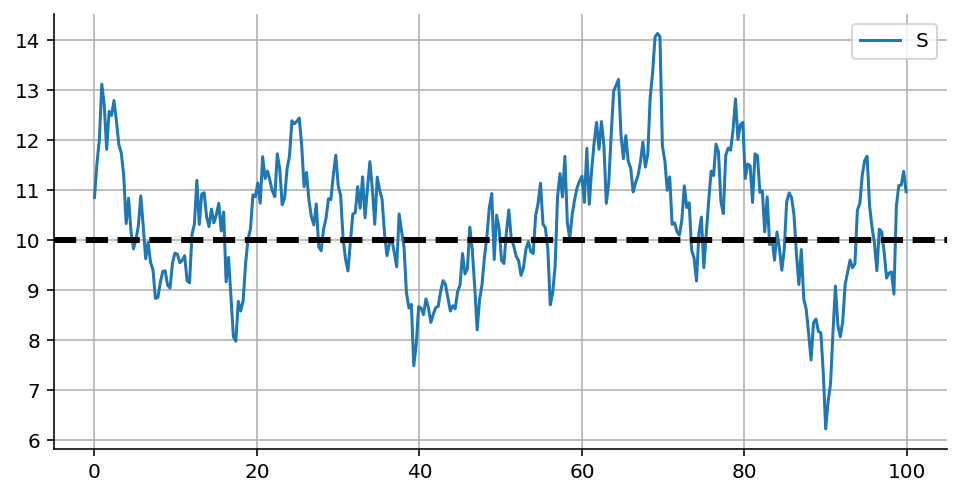

In [18]:
St_test.plot()
plt.grid()
plt.axhline(y=xbar, linewidth=3, c="black", linestyle="--", zorder=2)

In [19]:
X_test = ts_supervised(St_test, n_in=n_in, n_out=n_out)

X_test_below = X_test[X_test["S(t)"] < xbar]

In [20]:
y_test_below = (X_test_below.iloc[:, -4:] > xbar).any(axis=1) * 1.
X_test_below = X_test_below.loc[:, :"S(t)"].values

In [21]:
y_test_below.value_counts()

1.0    68
0.0    56
dtype: int64

In [22]:
y_test_below.mean()

0.5483870967741935

In [23]:
D = np.sum((X_test_below[:, None, :] - X_below[None, ...]) ** 2, axis=-1)
D.shape

(124, 631)

In [24]:
samples_mcmc = chains[:, burnout:, :].reshape(-1, 2)
D_argsort = D.argsort()

In [25]:
n_samples, _ = samples_mcmc.shape
Q = 2
n_test, *_ = y_test_below.shape
classes = np.arange(Q)
P_grid = np.zeros((n_test, n_samples))
for i, (k_star, beta_star) in tqdm(enumerate(samples_mcmc), total=n_samples):
    k_star = int(k_star)
    nearest = D_argsort[..., :k_star]
    y_nearest = y_below.values[nearest]
    num = y_nearest == 1
    num = np.exp(beta_star * num.mean(axis=-1))
    
    den = y_nearest[..., None] == classes[None, None, :]
    den = np.exp(beta_star * den.mean(axis=1)).sum(axis=-1)
    
    P_grid[:, i] = num / den

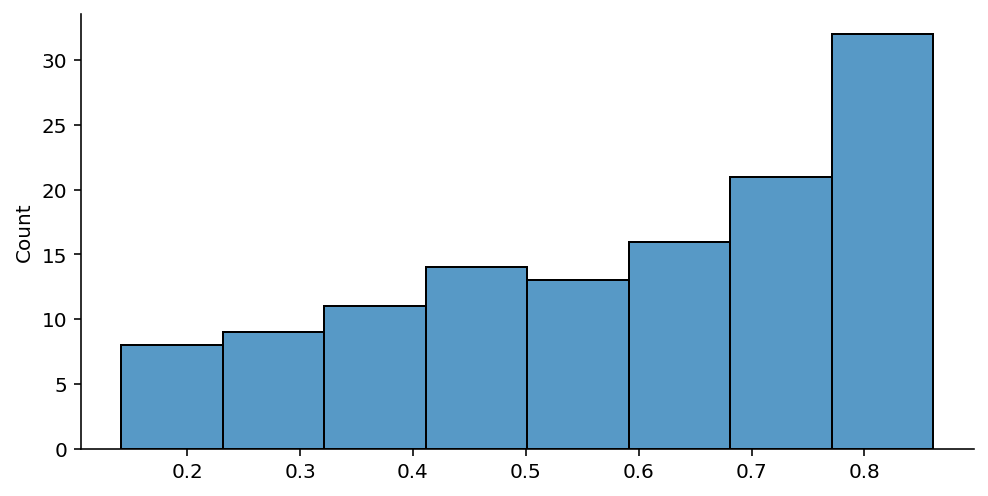

In [26]:
y_test_proba = P_grid.mean(axis=1)
y_test_std = P_grid.std(axis=1)
sns.histplot(y_test_proba);

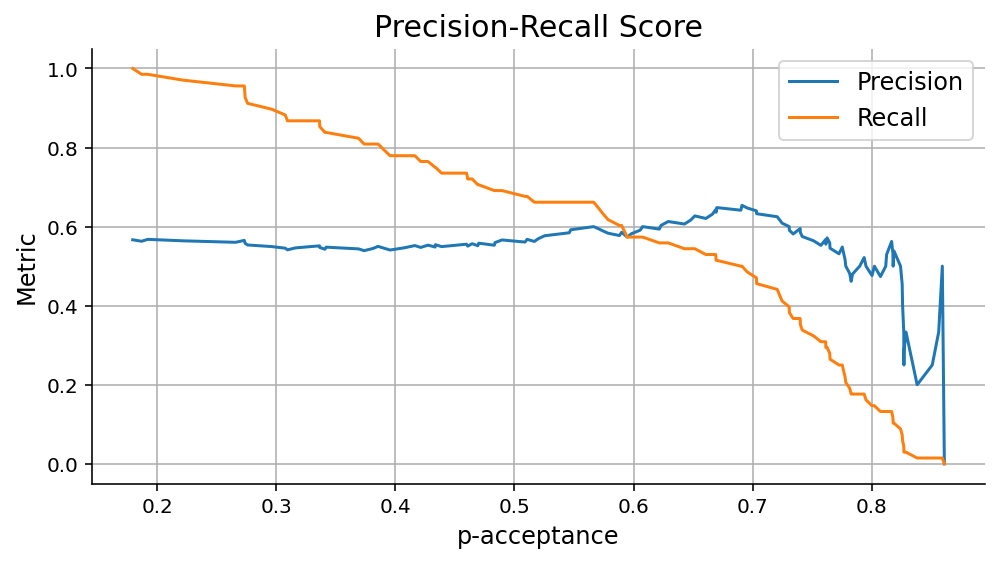

In [27]:
prec, rec, threshold = precision_recall_curve(y_test_below, y_test_proba)
plt.plot(threshold, prec[:-1], label="Precision")
plt.plot(threshold, rec[:-1], label="Recall")
plt.legend(fontsize=12)
plt.title("Precision-Recall Score", fontsize=15)
plt.xlabel("p-acceptance", fontsize=12)
plt.ylabel("Metric", fontsize=12)
plt.grid()

In [28]:
y_test_pred = y_test_proba > 0.6

In [29]:
confusion_matrix(y_test_below, y_test_pred)

array([[29, 27],
       [29, 39]])

In [30]:
# tp / (tp + fp)
precision_score(y_test_below, y_test_pred)

0.5909090909090909

In [31]:
# tp / (tp + fn)
recall_score(y_test_below, y_test_pred)

0.5735294117647058

### Probabilistic choice criterion

In [32]:
y_test_range = y_test_proba[:, None] + np.array([[-1, 1]]) * P_grid.std(axis=1, keepdims=True)
y_test_pred = (y_test_range > 0.6).all(axis=1)
#y_test_pred = ~(P_grid <= 0.5).any(axis=1) & (y_test_range > 0.5).all(axis=1) 

In [33]:
confusion_matrix(y_test_below, y_test_pred)

array([[32, 24],
       [30, 38]])

In [34]:
P_grid.shape

(124, 6000)

In [35]:
# tp / (tp + fp)
precision_score(y_test_below, y_test_pred)

0.6129032258064516

In [36]:
# tp / (tp + fn)
recall_score(y_test_below, y_test_pred)

0.5588235294117647

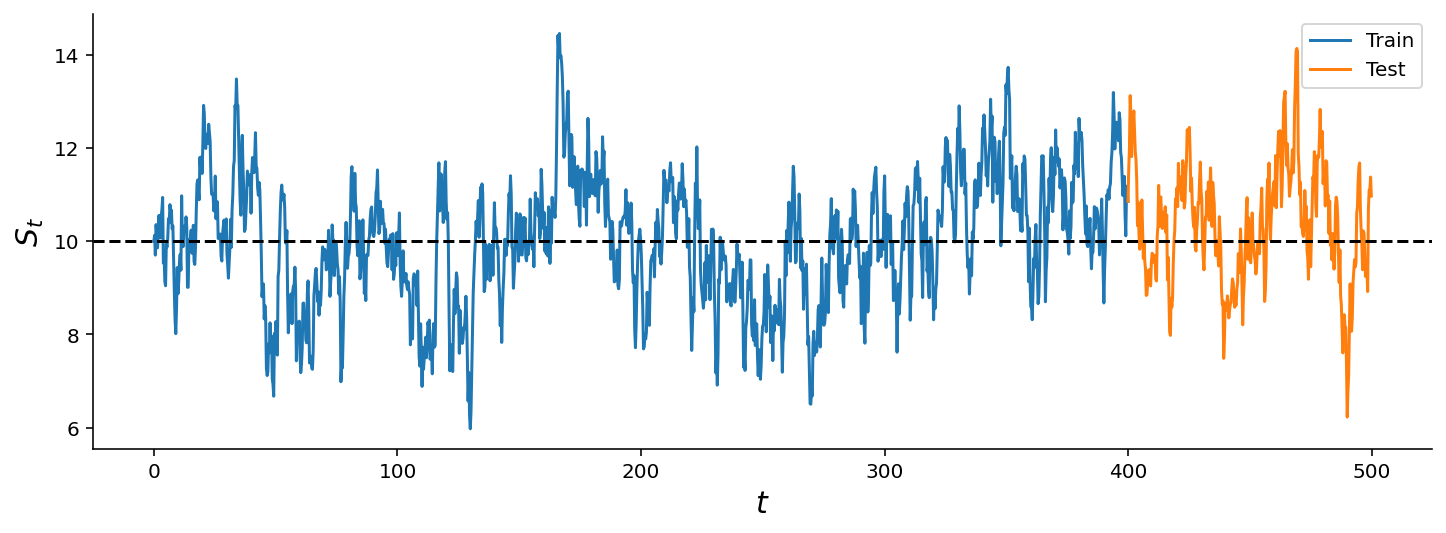

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
St.rename({"S": "Train"}, axis=1).plot(ax=ax)
St_test.rename({"S": "Test"}, axis=1).set_index(St_test.index + St.index.max()).plot(ax=ax)
plt.axhline(y=xbar, c="black", linestyle="--")
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$S_t$", fontsize=15);

### Reviewing decision

In [38]:
# Indices where the probability criteria are met
np.where(y_test_pred)

(array([  0,   1,   2,   3,   4,   5,  20,  21,  22,  23,  24,  26,  27,
         28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  45,  65,  66,  71,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 104, 121, 122, 123]),)

In [111]:
test_index = 104
test_index = 100
P_grid[test_index].mean()

0.545955333006407

In [112]:
Dx = compute_distance(X_test_below.T, X_below)
k = 20
nearest_test = np.argsort(Dx)[..., :k]

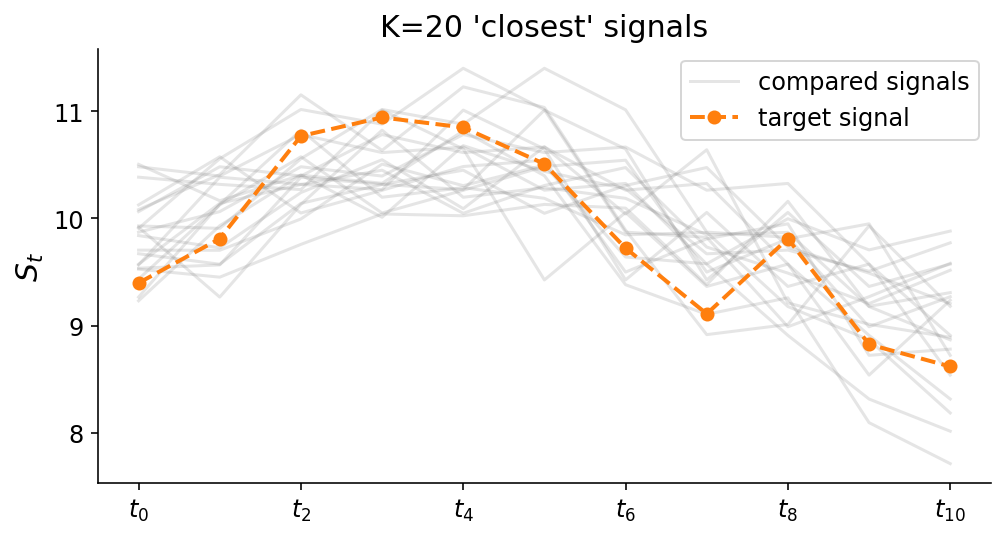

In [117]:
l1 = plt.plot(X_below[nearest_test[test_index]].T, c="tab:gray", alpha=0.2, label="compared signals")
l2 = plt.plot(X_test_below[test_index], c="tab:orange", linestyle="--",
              marker="o", label="target signal", linewidth=2)
plt.ylabel("$S_t$", fontsize=15)
xticks = range(0, 11, 2) 
xticks_labels = ["$t_{tt}$".replace("tt", str(t)) for t in xticks]
plt.xticks(xticks, xticks_labels, fontsize=12)
plt.yticks(range(8, 12), fontsize=12)

legends = l1[:1] + l2
labels = [l.get_label() for l in legends]
plt.legend(legends, labels, fontsize=12)
plt.title(f"K={k} 'closest' signals", fontsize=15);
plt.savefig("St2.pdf");

In [239]:
y_test_below.iloc[test_index]

0.0

In [241]:
# Indices where the probability criteria are met
np.where(y_test_pred)

(array([  0,   1,   2,   3,   4,   5,  20,  21,  22,  23,  24,  26,  27,
         28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  45,  65,  66,  71,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 104, 121, 122, 123]),)

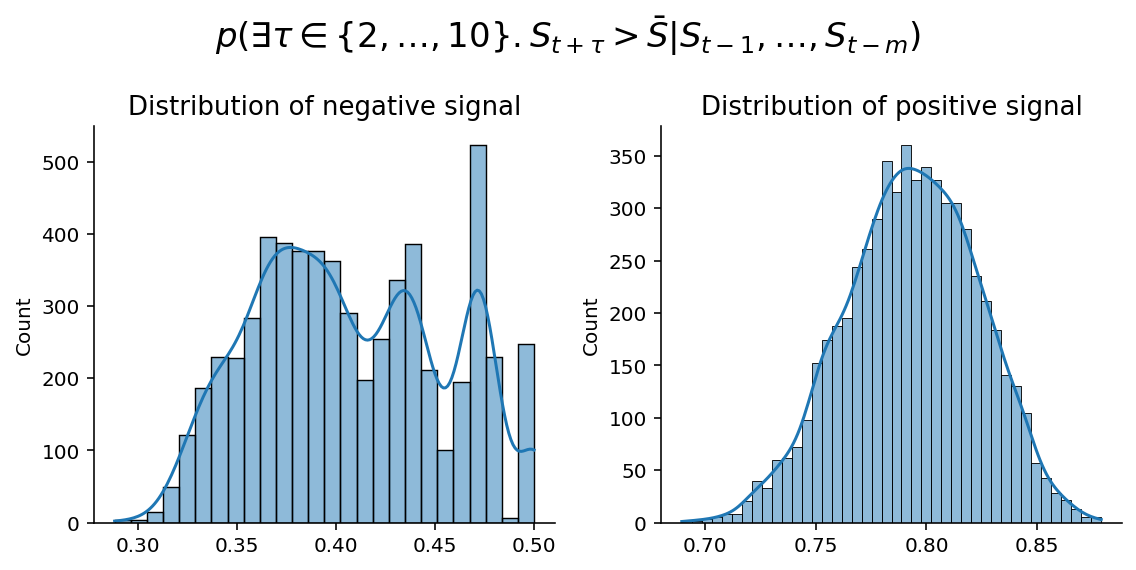

In [290]:
fig, ax = plt.subplots(1, 2)
sns.histplot(P_grid[10], ax=ax[0], kde=True)
sns.histplot(P_grid[123], ax=ax[1], kde=True)
ax[0].set_title("Distribution of negative signal", fontsize=13)
ax[1].set_title("Distribution of positive signal", fontsize=13)
title = r"$p(\exists \tau\in\{2, \ldots, 10\}. S_{t+\tau} > \bar S\vert S_{t-1}, \ldots, S_{t-m})$"
plt.suptitle(title, fontsize=17)
plt.tight_layout()
#plt.savefig("signal-distribution.pdf")

In [288]:
y_test_below.iloc[10]

0.0

In [289]:
y_test_below.iloc[123]

1.0